# Hysteresis Loops Fitting

In [1]:
import sys
sys.path.append('../../')
# sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")
sys.path.append('../../src')

In [2]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.viz.layout import subfigures

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
# from m3_learning.nn.Fitter1D.Fitter1D_new import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads data

In [3]:
# Specify the filename and the path to save the file
filename = './data_raw_unmod.h5'
save_path = "./Data"

data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, SHO_fit_func_LSQF=SHO_fit_func_nn)

# print the contents of the file
dataset.print_be_tree()

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
   

## Performs SHO fits

In [4]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit()

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000" (11 members)>]
Returned previously computed results at /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_0

/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/home/alk224/miniconda3/envs/alibek/lib/python3.9/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


## Visualize LSQF fit results

In [5]:
# instantiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

# instantiate the dataset object
dataset = BE_Dataset(data_path)

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/hysteresis_comparison.png
./Figures/hysteresis_comparison.svg


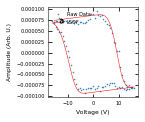

In [6]:
BE_viz.hysteresis_comparison(data = ['LSQF'])

## Neural Network Fits

In [7]:
dataset.loop_param_scaler

StandardScaler()

In [8]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [9]:
dataset.hysteresis_scaler

In [54]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.optimizers.TrustRegion import TRCG
import torch.optim as optim


data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
# V = np.swapaxes(np.atleast_2d(dataset.get_voltage), 0, 1).astype(np.float64)


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
                            voltage[:,0].squeeze(), # x data
#                             V.squeeze(),
                            1, # input channels
                            9, # output parameters
                            dataset.loop_param_scaler,
                            loops_scaler=dataset.hysteresis_scaler)

# instantiate the model
model = Model(model_, dataset, training=True, model_basename="SHO_Fitter_original_data")

from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(data.reshape(-1,96), test_size=0.2, random_state=42, shuffle=True)

X_train = np.atleast_3d(X_train)

optimizer = {
    "name": "TRCG", 
    "optimizer": TRCG,
    "closure_size": 1,
    "cgopttol": 1e-3,
    "c0tr": 0.2,
    "c1tr": 0.25,
    "c2tr": 0.75,
    "t1tr": 0.75,
    "t2tr": 2.0,
    "radius_max": 5.0,  
    "radius_initial": 1.0,
    "radius" : 1.0,
    "device": "cuda",
    "ADAM_epochs": 500}


train = True

if train:
    # fits the model
    model.fit(
        X_train,
        1024,
        optimizer=optimizer,
        epochs = 600,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values
Using GPU A100-SXM4-40GB
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Adam
epoch : 1/600, recon loss = 0.16053447
--- 0.11719346046447754 seconds ---
Epoch 1, Learning Rate: 0.001
Adam
epoch : 2/600, recon loss = 0.13272373
--- 0.11026859283447266 seconds ---
Epoch 2, Learning Rate: 0.001
Adam
epoch : 3/600, recon loss = 0.11636056
--- 0.10895013809204102 seconds ---
Epoch 3, Learning Rate: 0.001
Adam
epoch : 4/600, recon loss = 0.09857615
--- 0.10813379287719727 seconds ---
Epoch 4, Learning Rate: 0.001
Adam
epoch : 5/600, recon loss = 0.08281183
--- 0.10660290718078613 seconds ---
Epoch 5, Learning Rate: 0.001
Adam
epoch : 6/600, recon loss = 0.06523578
--- 0.10670185089111328 seconds ---
Epoch 6, Learning Rate: 0.001
Adam
epoch : 7/600, recon loss = 0

Adam
epoch : 72/600, recon loss = 0.01067348
--- 0.10575246810913086 seconds ---
Epoch 72, Learning Rate: 0.001
Adam
epoch : 73/600, recon loss = 0.01067862
--- 0.1096956729888916 seconds ---
Epoch 73, Learning Rate: 0.001
Adam
epoch : 74/600, recon loss = 0.01056548
--- 0.10630226135253906 seconds ---
Epoch 74, Learning Rate: 0.001
Adam
epoch : 75/600, recon loss = 0.01072000
--- 0.10621404647827148 seconds ---
Epoch 75, Learning Rate: 0.001
Adam
epoch : 76/600, recon loss = 0.01050678
--- 0.1056218147277832 seconds ---
Epoch 76, Learning Rate: 0.001
Adam
epoch : 77/600, recon loss = 0.01039993
--- 0.1059567928314209 seconds ---
Epoch 77, Learning Rate: 0.001
Adam
epoch : 78/600, recon loss = 0.01033688
--- 0.10636186599731445 seconds ---
Epoch 78, Learning Rate: 0.001
Adam
epoch : 79/600, recon loss = 0.01038223
--- 0.1066737174987793 seconds ---
Epoch 79, Learning Rate: 0.001
Adam
epoch : 80/600, recon loss = 0.01050547
--- 0.10684084892272949 seconds ---
Epoch 80, Learning Rate: 0.

Adam
epoch : 146/600, recon loss = 0.00889051
--- 0.10594987869262695 seconds ---
Epoch 146, Learning Rate: 0.001
Adam
epoch : 147/600, recon loss = 0.00887295
--- 0.10583853721618652 seconds ---
Epoch 147, Learning Rate: 0.001
Adam
epoch : 148/600, recon loss = 0.00883919
--- 0.10532975196838379 seconds ---
Epoch 148, Learning Rate: 0.001
Adam
epoch : 149/600, recon loss = 0.00885877
--- 0.1053171157836914 seconds ---
Epoch 149, Learning Rate: 0.001
Adam
epoch : 150/600, recon loss = 0.00885740
--- 0.10590124130249023 seconds ---
Epoch 150, Learning Rate: 0.001
Adam
epoch : 151/600, recon loss = 0.00888170
--- 0.10576891899108887 seconds ---
Epoch 151, Learning Rate: 0.001
Adam
epoch : 152/600, recon loss = 0.00887152
--- 0.10657525062561035 seconds ---
Epoch 152, Learning Rate: 0.001
Adam
epoch : 153/600, recon loss = 0.00887631
--- 0.10622811317443848 seconds ---
Epoch 153, Learning Rate: 0.001
Adam
epoch : 154/600, recon loss = 0.00888263
--- 0.10601139068603516 seconds ---
Epoch 1

Adam
epoch : 218/600, recon loss = 0.00835774
--- 0.10648250579833984 seconds ---
Epoch 218, Learning Rate: 0.001
Adam
epoch : 219/600, recon loss = 0.00838792
--- 0.10674905776977539 seconds ---
Epoch 219, Learning Rate: 0.001
Adam
epoch : 220/600, recon loss = 0.00829268
--- 0.10625576972961426 seconds ---
Epoch 220, Learning Rate: 0.001
Adam
epoch : 221/600, recon loss = 0.00824570
--- 0.10583662986755371 seconds ---
Epoch 221, Learning Rate: 0.001
Adam
epoch : 222/600, recon loss = 0.00824080
--- 0.10605525970458984 seconds ---
Epoch 222, Learning Rate: 0.001
Adam
epoch : 223/600, recon loss = 0.00820857
--- 0.10573434829711914 seconds ---
Epoch 223, Learning Rate: 0.001
Adam
epoch : 224/600, recon loss = 0.00820937
--- 0.10583710670471191 seconds ---
Epoch 224, Learning Rate: 0.001
Adam
epoch : 225/600, recon loss = 0.00818507
--- 0.10593748092651367 seconds ---
Epoch 225, Learning Rate: 0.001
Adam
epoch : 226/600, recon loss = 0.00818702
--- 0.10695767402648926 seconds ---
Epoch 

Adam
epoch : 291/600, recon loss = 0.00752158
--- 0.10595154762268066 seconds ---
Epoch 291, Learning Rate: 0.001
Adam
epoch : 292/600, recon loss = 0.00750169
--- 0.10643887519836426 seconds ---
Epoch 292, Learning Rate: 0.001
Adam
epoch : 293/600, recon loss = 0.00750306
--- 0.10619640350341797 seconds ---
Epoch 293, Learning Rate: 0.001
Adam
epoch : 294/600, recon loss = 0.00752313
--- 0.10588288307189941 seconds ---
Epoch 294, Learning Rate: 0.001
Adam
epoch : 295/600, recon loss = 0.00758270
--- 0.10668396949768066 seconds ---
Epoch 295, Learning Rate: 0.001
Adam
epoch : 296/600, recon loss = 0.00755414
--- 0.10580253601074219 seconds ---
Epoch 296, Learning Rate: 0.001
Adam
epoch : 297/600, recon loss = 0.00758173
--- 0.10568714141845703 seconds ---
Epoch 297, Learning Rate: 0.001
Adam
epoch : 298/600, recon loss = 0.00751823
--- 0.10650873184204102 seconds ---
Epoch 298, Learning Rate: 0.001
Adam
epoch : 299/600, recon loss = 0.00759061
--- 0.10616803169250488 seconds ---
Epoch 

Adam
epoch : 363/600, recon loss = 0.00713041
--- 0.10577750205993652 seconds ---
Epoch 363, Learning Rate: 0.001
Adam
epoch : 364/600, recon loss = 0.00709005
--- 0.10737013816833496 seconds ---
Epoch 364, Learning Rate: 0.001
Adam
epoch : 365/600, recon loss = 0.00711200
--- 0.10674500465393066 seconds ---
Epoch 365, Learning Rate: 0.001
Adam
epoch : 366/600, recon loss = 0.00711079
--- 0.10695338249206543 seconds ---
Epoch 366, Learning Rate: 0.001
Adam
epoch : 367/600, recon loss = 0.00714787
--- 0.10581541061401367 seconds ---
Epoch 367, Learning Rate: 0.001
Adam
epoch : 368/600, recon loss = 0.00727562
--- 0.10550284385681152 seconds ---
Epoch 368, Learning Rate: 0.001
Adam
epoch : 369/600, recon loss = 0.00711346
--- 0.10587763786315918 seconds ---
Epoch 369, Learning Rate: 0.001
Adam
epoch : 370/600, recon loss = 0.00716278
--- 0.10602736473083496 seconds ---
Epoch 370, Learning Rate: 0.001
Adam
epoch : 371/600, recon loss = 0.00761494
--- 0.10605502128601074 seconds ---
Epoch 

Adam
epoch : 435/600, recon loss = 0.00701280
--- 0.10676813125610352 seconds ---
Epoch 435, Learning Rate: 0.001
Adam
epoch : 436/600, recon loss = 0.00702150
--- 0.1066889762878418 seconds ---
Epoch 436, Learning Rate: 0.001
Adam
epoch : 437/600, recon loss = 0.00700362
--- 0.10671758651733398 seconds ---
Epoch 437, Learning Rate: 0.001
Adam
epoch : 438/600, recon loss = 0.00692593
--- 0.10743165016174316 seconds ---
Epoch 438, Learning Rate: 0.001
Adam
epoch : 439/600, recon loss = 0.00693988
--- 0.10634660720825195 seconds ---
Epoch 439, Learning Rate: 0.001
Adam
epoch : 440/600, recon loss = 0.00692280
--- 0.10591745376586914 seconds ---
Epoch 440, Learning Rate: 0.001
Adam
epoch : 441/600, recon loss = 0.00703976
--- 0.10574960708618164 seconds ---
Epoch 441, Learning Rate: 0.001
Adam
epoch : 442/600, recon loss = 0.00695820
--- 0.10577678680419922 seconds ---
Epoch 442, Learning Rate: 0.001
Adam
epoch : 443/600, recon loss = 0.00704765
--- 0.10544013977050781 seconds ---
Epoch 4

Trust Region CG
epoch : 507/600, recon loss = 0.00657075
--- 2.604154109954834 seconds ---
Epoch 507, Learning Rate: 0.001
Trust Region CG
epoch : 508/600, recon loss = 0.00658649
--- 3.7255916595458984 seconds ---
Epoch 508, Learning Rate: 0.001
Trust Region CG
epoch : 509/600, recon loss = 0.00653923
--- 3.789977550506592 seconds ---
Epoch 509, Learning Rate: 0.001
Trust Region CG
epoch : 510/600, recon loss = 0.00651424
--- 4.75180983543396 seconds ---
Epoch 510, Learning Rate: 0.001
Trust Region CG
epoch : 511/600, recon loss = 0.00650196
--- 3.2109105587005615 seconds ---
Epoch 511, Learning Rate: 0.001
Trust Region CG
epoch : 512/600, recon loss = 0.00648919
--- 5.953215837478638 seconds ---
Epoch 512, Learning Rate: 0.001
Trust Region CG
epoch : 513/600, recon loss = 0.00649696
--- 6.826849460601807 seconds ---
Epoch 513, Learning Rate: 0.001
Trust Region CG
epoch : 514/600, recon loss = 0.00647189
--- 5.2470033168792725 seconds ---
Epoch 514, Learning Rate: 0.001
Trust Region C

Trust Region CG
epoch : 574/600, recon loss = 0.00590133
--- 5.172193765640259 seconds ---
Epoch 574, Learning Rate: 0.001
Trust Region CG
epoch : 575/600, recon loss = 0.00590035
--- 6.535629510879517 seconds ---
Epoch 575, Learning Rate: 0.001
Trust Region CG
epoch : 576/600, recon loss = 0.00589585
--- 4.905837059020996 seconds ---
Epoch 576, Learning Rate: 0.001
Trust Region CG
epoch : 577/600, recon loss = 0.00589744
--- 2.9836552143096924 seconds ---
Epoch 577, Learning Rate: 0.001
Trust Region CG
epoch : 578/600, recon loss = 0.00588858
--- 3.5473642349243164 seconds ---
Epoch 578, Learning Rate: 0.001
Trust Region CG
epoch : 579/600, recon loss = 0.00587695
--- 3.3917951583862305 seconds ---
Epoch 579, Learning Rate: 0.001
Trust Region CG
epoch : 580/600, recon loss = 0.00588456
--- 4.088550329208374 seconds ---
Epoch 580, Learning Rate: 0.001
Trust Region CG
epoch : 581/600, recon loss = 0.00588846
--- 4.136502504348755 seconds ---
Epoch 581, Learning Rate: 0.001
Trust Region 

In [55]:
import torch
X_train = torch.atleast_3d(torch.tensor(X_train))


train_pred_recon, train_pred_params_scaled, train_pred_params = model.predict(
    X_train,
    1024,
    translate_params=False,
    is_SHO=False
)

In [56]:
train_pred_recon.shape
train_pred_params_scaled.shape
train_pred_params.shape

torch.Size([11520, 9])

In [57]:
X_train[1000].shape

torch.Size([96, 1])

In [58]:
voltage.shape

(96, 1)

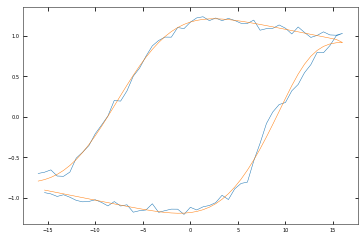

In [59]:
i = np.random.randint(0, X_train.shape[0])

import matplotlib.pyplot as plt
plt.plot(voltage, X_train[i])
plt.plot(voltage, np.atleast_2d(train_pred_recon[i]))

### Evaluate the Neural Network Results

/home/alk224/workspace/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/viz.py:1015: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(true).float()


./Figures/Figure_X_NN_validation_Train.png
./Figures/Figure_X_NN_validation_Train.svg


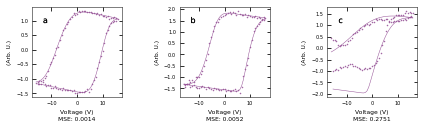

In [60]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Train",
)

./Figures/Figure_X_NN_validation_Test.png
./Figures/Figure_X_NN_validation_Test.svg


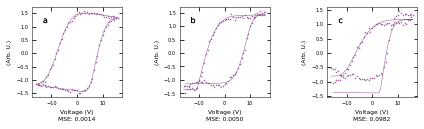

In [61]:
X_test = torch.atleast_3d(torch.tensor(X_test))

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Test",
)

### Calculate the MSE

In [62]:
data_ = (torch.atleast_3d(torch.tensor(data.reshape(-1, 96))), X_test, X_train)
labels = ["Full Data", "Test Data", "Train Data"]

model.print_mse(data_, labels, is_SHO=False)

Full Data Mean Squared Error: 0.0059
Test Data Mean Squared Error: 0.0057
Train Data Mean Squared Error: 0.0059


## Comparison of LSQF and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/Figure_XX_LSQF_NN_bmw_comparison.png
./Figures/Figure_XX_LSQF_NN_bmw_comparison.svg


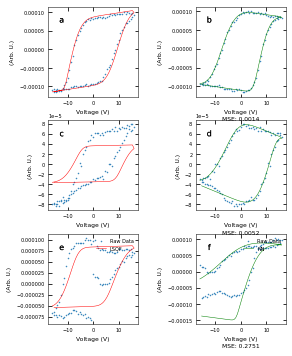

In [63]:
n = 1

data = ("LSQF", "NN")
# names = ["LSQF", "NN"]

BE_viz.hysteresis_comparison(
    data,
    model=model,
    filename="Figure_XX_LSQF_NN_bmw_comparison",
)

### Statistics of the Results for Training, Validation, and Entire Dataset

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/Figure_XX_Violin.png
./Figures/Figure_XX_Violin.svg


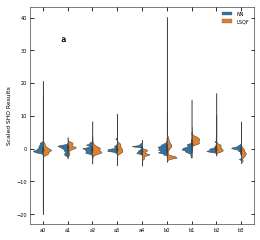

In [64]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

BE_viz.violin_plot_comparison_hysteresis(model,
                                         torch.atleast_3d(torch.tensor(data.reshape(-1, 96))),
                                         filename="Figure_XX_Violin") 

### Color Maps of Parameters

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Raw_Data_SHO_Fit/Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/Figure_XX_NN_Hysteresis_Maps.png
./Figures/Figure_XX_NN_Hysteresis_Maps.svg


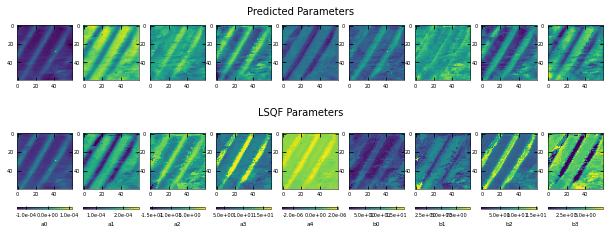

In [65]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
data = torch.atleast_3d(torch.tensor(data.reshape(-1, 96)))

pred_recon, pred_params_scaled, pred_params = model.predict(
    data,
    1024,
    translate_params=False,
    is_SHO=False
)

BE_viz.hysteresis_maps(pred_params, filename="Figure_XX_NN_Hysteresis_Maps")